In [ ]:
# google colab で実行する場合は以下のコメントアウトを外す
# ! wget https://indexes.nikkei.co.jp/nkave/historical/nikkei_stock_average_daily_jp.csv
# ! pip install numpy==1.26.4
# ! pip install pandas==2.1.4
# ! pip install pmdarima

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pmdarima import auto_arima
from warnings import simplefilter
simplefilter("ignore", FutureWarning)  # FutureWarningを無視する

In [2]:
# 日経平均株価のデータフレームを作成
# (最後の行の利用方法の説明は、skipfooter=1 でデータフレームに取り込まない)
stock_df = pd.read_csv('nikkei_stock_average_daily_jp.csv', encoding='cp932', skipfooter=1, engine='python')['終値']
print('データ数', len(stock_df))
print('データフレームの末尾1行\n', stock_df.tail(1))

データ数 842
データフレームの末尾1行
 841    39134.79
Name: 終値, dtype: float64


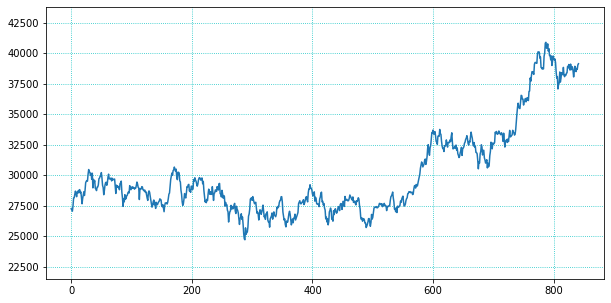

In [3]:
# 日経平均株価のグラフを表示
fig = plt.figure(figsize=(10,5))  
ax = fig.add_subplot(111)
ax.plot(stock_df)
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min * 0.9, y_max * 1.05)
ax.grid(axis='both',linestyle='dotted', color='c')

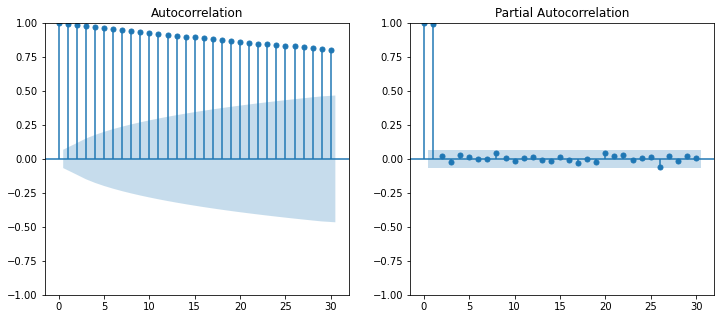

In [4]:
# 自己相関係数と偏自己相関係数のグラフを表示
fig = plt.figure(figsize=(12, 5))  
ax1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(stock_df, ax=ax1)
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(stock_df, ax=ax2, method='ywm')

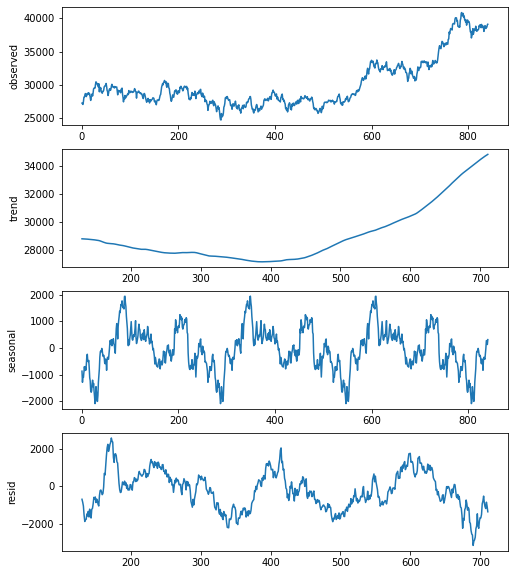

In [5]:
# 時系列データをトレンド、規則的変動成分、不規則変動成分に分解
# 260=5*52
res = sm.tsa.seasonal_decompose(stock_df, period=260) 
fig = plt.figure(figsize=(8, 10))
ax1 = fig.add_subplot(411)
ax1.set_ylabel('observed')
ax1.plot(res.observed)
ax2 = fig.add_subplot(412)
ax2.set_ylabel('trend')
ax2.plot(res.trend)
ax3 = fig.add_subplot(413)
ax3.set_ylabel('seasonal')
ax3.plot(res.seasonal)
ax4 = fig.add_subplot(414)
ax4.set_ylabel('resid')
ax4.plot(res.resid)


In [6]:
# モデル構築と検証のためのデータを準備
train = stock_df[0:840]  # 学習用データ 
test = stock_df[840:]  # 検証用データ 

In [ ]:
# pmdarima を利用して、SARIMAX の最適次数を探索
stepwise_fit = auto_arima(train, 
                          seasonal=True, 
                          trace=True, 
                          m=25, 
                          stepwise=True)                         
stepwise_fit.summary()

# m=75 ARIMA(0,1,0)(0,0,0)[75]  : AIC=12120.587
# m=25 ARIMA(0,1,0)(0,0,1)[25]  : AIC=12118.995 **
# m=5  ARIMA(0,1,0)(0,0,0)[5]   : AIC=12120.587

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[25] intercept   : AIC=12188.518, Time=3.80 sec
 ARIMA(0,1,0)(0,0,0)[25] intercept   : AIC=12187.166, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[25] intercept   : AIC=12187.161, Time=0.94 sec
 ARIMA(0,1,1)(0,0,1)[25] intercept   : AIC=12187.437, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[25]             : AIC=12186.478, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[25] intercept   : AIC=12186.531, Time=0.41 sec
 ARIMA(0,1,0)(0,0,1)[25] intercept   : AIC=12186.661, Time=0.29 sec
 ARIMA(0,1,0)(1,0,1)[25] intercept   : AIC=12188.135, Time=0.77 sec
 ARIMA(1,1,0)(0,0,0)[25] intercept   : AIC=12187.799, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[25] intercept   : AIC=12187.941, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[25] intercept   : AIC=12183.714, Time=0.24 sec
 ARIMA(1,1,1)(1,0,0)[25] intercept   : AIC=12183.379, Time=1.44 sec
 ARIMA(1,1,1)(2,0,0)[25] intercept   : AIC=12184.853, Time=6.64 sec
 ARIMA(1,1,1)(1,0,1)[25] intercept   : AIC=12184.624, Time=1.77 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  840
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 25)   Log Likelihood               -6087.205
Date:                             Wed, 12 Jun 2024   AIC                          12182.409
Time:                                     13:53:58   BIC                          12201.338
Sample:                                          0   HQIC                         12189.665
                                             - 840                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9072      0.080    -11.351      0.000      -1.064      -0.751
ma.L1          0.8702      0.093      9.321      0.000       0.687       1.053
ar.S.L25       0.0556      0.033      1.665      0.096      -0.010       0.121
sigma2      1.178e+05   5623.137     20.944      0.000    1.07e+05    1.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.88   Prob(JB):                         0.51
Heteroskedasticity (H):               1.16   Skew:                            -0.07
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

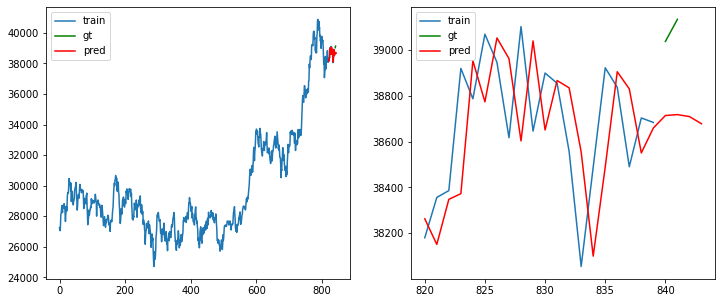

In [8]:
# pmdarima で探索した最適次数を利用してモデルを作成
# SARIMA = sm.tsa.SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 0, 1, 25)).fit()
SARIMA = sm.tsa.SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 0, 25)).fit()
pred = SARIMA.predict(820, 843)

# 実データと予測結果の図示
fig = plt.figure(figsize=(12, 5))  
ax1 = fig.add_subplot(121)
ax1.plot(train, label="train")
ax1.plot(test, "g", label="gt")
ax1.plot(pred, "r", label="pred")
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(stock_df[820:840], label="train")
ax2.plot(test, "g", label="gt")
ax2.plot(pred, "r", label="pred")
ax2.legend()

In [10]:
# モデル構築と検証のためのデータを準備
train = stock_df  # 学習用データ 
# pmdarima で探索した最適次数を利用してモデルを作成
# SARIMA = sm.tsa.SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 25)).fit()
SARIMA = sm.tsa.SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 0, 25)).fit()
# 学習データの範囲の次の日の終値を予測して表示
pred = SARIMA.predict(844)
print('予測値', pred)

予測値 844    39131.91689
dtype: float64
